Below I introduce the work I have done since Thanksgiving. This notebook first studies auto encoder and an improved auto encoder model proposed by Gu et al. (2019). It then analyzes this model and proposes my improved version on the auto encoder model proposed by the paper. To summarize, the work I have done includes the following:
* Conducted a detailed review on a paper on auto encoder asset pricing models
* Did improvement and proposed a time series based auto encoder asset pricing models
* Extended `Data` module in Stlearn framework to add a second implementation: data input pipeline based on generator that can greatly save the consumption of memory space, which is required by proposed model

# Review on literature model: Autoencoder Asset Pricing Models

Gu et al. (2019) proposed [a new conditional auto encoder model](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3335536) for individual stock returns which, allows covariates to help guide dimension reduction and proved their model outperformed prevail asset pricing models in out-sample tests. 

**<font size=5><u>Intuition</u></font>**

In their research, they first demonstrate how a standard auto encoder works, which is an unsupervised machine learning techniques and is featured by one stack of encoder layers followed by another stack of decoder layers to minimize the difference between inputs and outputs. In the context of stock selection, it is obvious that such inputs and outputs are stocks excessive returns. The authors then propose limitations on the sole use of such model: "The distribution of asset returns is well known to be highly time-varying, and static factor models abstract from a wealth of relevant conditioning information." It means the standard auto encoder model cannot obtain any conditional information relevant to the asset and instead can only rely on returns themselves. The authors hereby propose their methods to incorporate asset level conditional variables to enhance standard auto encoders.

At the highest level, this paper builds its estimation on KPS model, which uses the following formula to coordinate the relationship between asset level conditional variables (betas) and groups of asset returns (factors) and estimate the individual return accordingly: ${r_{i,t}}={\beta}{(}{z_{i,t-1}}{)}'{f_t}{+}u_{i,t}$. Here $f_t$ is the latent $K$ factors reduced from stock returns, ${\beta}{(}{z_{i,t-1}}{)}'$ is the conditional factor exposure which is a function of individual asset characteristics ${z_{i,t-1}}$.   

**<font size=5><u>Architecture</u></font>**

They hereby propose the following architecture:
* The left side models factor loadings ${\beta}{(}{z_{i,t-1}}{)}'$ with a neural network model converting asset characteristics to factor exposure
* The right side models factors $f_t$ with a standard auto encoder converting individual stock returns to factors as portfolios of individual stock returns

They then prove such arrangement can be rewritten as the KPS model mathematically.

Let's provide an overview of the layers in this architecture.
* On the left side, it has a neural network  to function as multiple layers of feature maps:
    * The input layer receives the feature set of all stocks asset level characteristics, which is in the shape of ${(N \times P)}$, where $N$ is the number of stocks and $P$ is the number of features
    * The hidden layers is not specified, it is inferred that this layers should be featured by units good at extracting features
    * The output layer outputs the set of all stocks' factor exposure, which is in the shape of ${(N \times K)}$, where $K$ is the number of factors
* On the right side, it has a standard auto encoder, it should takes in a ${(N \times 1)}$ label set of stock excessive returns. It should then encodes it into a intermediate encoded layer and then decodes it into the output layer which output tensor of shape ${(K \times 1)}$

<img src="./Stlearn/img/cvae.png" alt="framework" title="framework" width="40000" height="12000"/>

**<font size=5><u>Comments</u></font>**

This architecture is evolutionary because it successfully combines deep learning architecture with asset management theories, which makes black box such as deep neural networks fully explainable from the view of economics and financial market. The paper also proves that such model's prediction can produce great profits for asset management. However, we also conclude the following limitations on this paper's research:

<u>**Lack of clarification on auto encoder**</u>

It confuses readers of the paper when reading the right part of the model architecture. It is illustrated as a mapping from label to label, where the label in this context is stocks' excessive returns that we are predicting. However, it only makes sense when we input what we are going to predict with model when we are training the model. And this architecture doesn't clarify on what they are going to input during the validation and test stage when the model is expected to make some predictions, under which circumstance, it can only access feature set $X$. In fact, auto encoder can be divided into multiple groups and each group may have different arrangements. In the context of financial market, our best guess is variational auto encoder, which use probability distribution layer to sample input and mimic the output of encoder layer when making predictions.

<u>**Failure to incorporate time series model**</u>

We observe the lack of time series components in this model. This can cause two drawbacks. First, it means this model can only predict future stock returns one time step ahead. Thus the model cannot be generated to that can predict returns multiple days or months ahead. This makes the model less useful to portfolio management, whose rebalance frequency is usually less than once a day. Secondly, it doesn't have design to accommodate high dimensional time series features that look back a few days before, as the input dataset doesn't have the time axis in this architecture. This naturally limits model's ability to extract time series information, thus negating stock returns' nature to be time series.

# An improved asset return prediction neural network based on auto regressor and auto encoder: Autoregressor-Autoencoder Asset Pricing Model

**<font size=5><u>Architecture</u></font>**

According to the analysis on limitations of the model mentioned above, we improve the architecture and propose it as follow. To be specific, we add accommodations to make the model handle time series data. We also specify a variational auto encoder structure to make full clarification on its mechanism on different stages of deep learning task.

<img src="./Stlearn/img/nvae.jpg" alt="framework" title="framework" width="40000" height="12000"/>

<u>**Inputs and outputs**</u>

We would like the model to handle time series data. As a result, we require the model to take in a 4-dimensional feature dataset and a 4-dimensional label dataset as inputs and output a 4-dimensional label dataset as predictions. To be specific: 
* the 4-dimensional feature dataset is in shape of $($*number of dates (number of samples), size of look back window, number of stocks, number of features*$)$
* the 4-dimensional label dataset is in shape of $($*number of dates (number of samples), size of predict forward window, number of stocks, 1*$)$

Note for convenience from now on all shape will be denoted by formula and scripts, and all first dimension (number of dates (number of samples)) will be neglected and thus reduced from the notion of shape.

<u>**Auto regressor based factor exposure layers**</u>

This part of layers expects to receive an input of shape $(, T_w, N_s, N_f)$. It then reshape and go through multiple feature map layers to convert it into shape $(, T_w, N_s \times K)$. The feature map layers consist of multiple dense and Conv1d layers.

This part of layers rely on auto regressor as a core to process time series data and output multi-step predictions. On the high level, auto regressor is warmed up with input features. It then starts to make predictions for multiple time steps. During each time step:
* It takes in inputs and outputs for previous time steps, and memorized states (LSTM only)
* It then make its prediction for this current time step
* It updates all the data mentioned above with the prediction of current time step to next time step  

We finally stack all these predictions for each time step to have a prediction looking forward on multi-step period.

At this time, we use RNN in warmup layers, and LSTM cells during each iteration of predict forward steps. Between layers, we use dense layer as feature maps to map shape from number of LSTM cell units to whichever shape we want. Finally the auto encoder outputs data in shape of $(, T_f, N_s \times K)$. Here, by "at this time" we mean temporarily because we can do more experiments on choosing layers in warmup layers and units during each iteration of predict forward steps.

At the very end of this part of layers, we go through multiple feature map layers and reshape output into shape $(, T_f, N_s, K)$. The feature map layers consist of multiple dense and Conv1d layers.

<u>**Variational auto encoder based factor reduction layers**</u>

On the training stage, this part of layers expects to receive an input shape of $(, T_f, N_s \times 1)$, which is exactly the stock excessive returns. It then goes into the encoder, where it goes through reshape layer and feature map layers to be transformed into a shape of $(, T_f, N_s)$. The data is then flattened and forwarded into feature map layers, and finally into an independent normal distribution layer. This layer generates samples according to learned probability distribution and output it as the encoded data of shape $(, T_f \times N_e)$. We then forward this encoded data into decoder, which carries the data through reshape layer and feature map layers, then finally into another independent normal distribution layer. This distribution layer generates samples according to learned probability distribution to reduced factors of shape $(, T_f, K, 1)$. The feature map layers mentioned above consist of multiple dense and Conv1d layers.

On the prediction stage, however, we should never expect to receive any label data (otherwise there will be data leakage issue). So we should generate encoded data in a generalization layer using similar sampling technique from independent normal distribution layer. We then forward such encoded data to the same well-trained decoder layer we mentioned above to make predictions.

<u>**Final prediction**</u>

Now we have two parts of layers.
* The factor exposure layers outputs the factor exposure for all stocks for each time step in the future of shape $(, T_f, N_s, K)$
* The reduced factor layers outputs the reduced factor for each time step in the future of shape $(, T_f, K, 1)$

We therefore do the dot product between the two 4-dimensional matrix and can get the final prediction for each stock's excessive returns for each time step in the future of $(, T_f, N_s, 1)$. Such operations can also be proved to obey the KPS formula easily.

**<font size=5><u>Remarks</u></font>**

The proposed new model incorporated time series models into the original Autoencoder Asset Pricing Model. And it is also raising the following issues and potential for improvements:

<u>**Need more robust and dataset and data input pipeline**</u>

As mentioned above, a 3-dimensional dataset incorporating time series features is huge, not to mention a 4-dimensional dataset with look back window size as the second dimension and the number of stocks as the third dimension. Previous statistics has presented that a one-year 3-dimensional dataset looking back 60 days before will crash python interpreter on a local machine with 16-GB RAM. Yet, for a 4-dimensional dataset with number of dates as the first dimension, a dataset covering one-year period means a dataset with as few samples as 252, which is too few for a model with millions of parameters. The only solution to handle this is to extend the current `Data` module and develop algorithm for data input pipeline that consumes constant memory space.

A second implication is more on design pattern perspective, that current single inheritance design of `Data` module cannot accommodate the evolution of demands. The previous premise for single inheritance design of is that data should have very limited kinds of implementation and transformation. Yet, the proposal of new model has undermined such assumption. On the high level, we currently have three dimensions of variance of data: whether to choose look back features, what shape of the data, which algorithm we will use to implement. Each of these three dimensions can be combined freely and will lead to 9 different classes if we follow single inheritance design, not to mention existence of other possible small dimensions. This will cause difficult for code's extendibility and maintenance. Thus, A new design must be proposed.

<u>**Need more research on model's components**</u>

In the future, we propose the following components of this model to research on:
* The components of auto regressor model. While the current implementation LSTM cell is well known for handling time series data, a couple of variants and combination with other types of units also deserve experiments
* The implementation of LSTM2D cell. The current implementation of TensorFlow on `LSTMCell` only supports an input of 2D tensor of shape $(batch, feature)$ for each timestep it is processing. Yet we have a demand for processing of 2-D features, which is an input of 3D tensor. The current solution is to reshape it into a 2D tensor before feeding it into the LSTM units, but a LSTM2D cell will be more supportive
* A probability layer fits the context of stock selection. We can think of researching on implement more robust probability layer based on stochastic process rather than only rely on normal distributions

Below is a training process for this proposed model. Both its training and validation loss are greatly less than the previous studied models.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/capstone/Deliverable/project')
sys.path.append('/content/drive/MyDrive/capstone/Deliverable/project/Stlearn')
from Stlearn import Constant
Constant.BATCH_SIZE = 32

from Stlearn.Factory import *
from Stlearn.Portfolio import *
from Stlearn.Data.DataProcessor import *

import numpy as np
import resource
from Stlearn.Callback import *
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss * 1024 / 1073741824)


processor = FourDimWinDataByDateByWinByStockByFeatureProcessor('2015-01-01', '2020-01-01', '2020-02-01', '2020-03-01', 30, 15, True)
data = processor.load_data()
data_train = data.get_train()
data_val = data.get_val()

print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss * 1024 / 1073741824)

0.5229606628417969
X_train shape: (1229, 30, 470, 152)
y_train shape: (1229, 15, 470, 1)
X_valid shape: (21, 30, 470, 152)
y_valid shape: (21, 15, 470, 1)
10.796283721923828


In [ ]:
model = ConditionalVariationalAutoEncoder()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=Constant.ERROR, metrics=[Constant.ERROR], weighted_metrics=[Constant.ERROR])
h = model.fit(data_train,
                                   epochs=Constant.MAX_EPOCHS,
                                   validation_data=data_val,
                                    callbacks=[MyCallback()]
                                   )

Epoch 1/10
     39/Unknown - 1599s 40s/step - loss: 0.0427 - mean_squared_error: 0.0427 - weighted_mean_squared_error: 0.0427 - max memory usage: 20.28738021850586
39/39 [==============================] - 1621s 41s/step - loss: 0.0427 - mean_squared_error: 0.0427 - weighted_mean_squared_error: 0.0427 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_weighted_mean_squared_error: 0.0126
Epoch 2/10
39/39 [==============================] - 1564s 40s/step - loss: 0.0051 - mean_squared_error: 0.0051 - weighted_mean_squared_error: 0.0051 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_weighted_mean_squared_error: 0.0183
Epoch 3/10
39/39 [==============================] - 1555s 40s/step - loss: 4.4418e-04 - mean_squared_error: 4.4418e-04 - weighted_mean_squared_error: 4.4418e-04 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_weighted_mean_squared_error: 0.0215
Epoch 4/10
39/39 [==============================] - 1539s 39s/step - loss: 2.6309e-04 - mean_squared_error

NameError: ignored

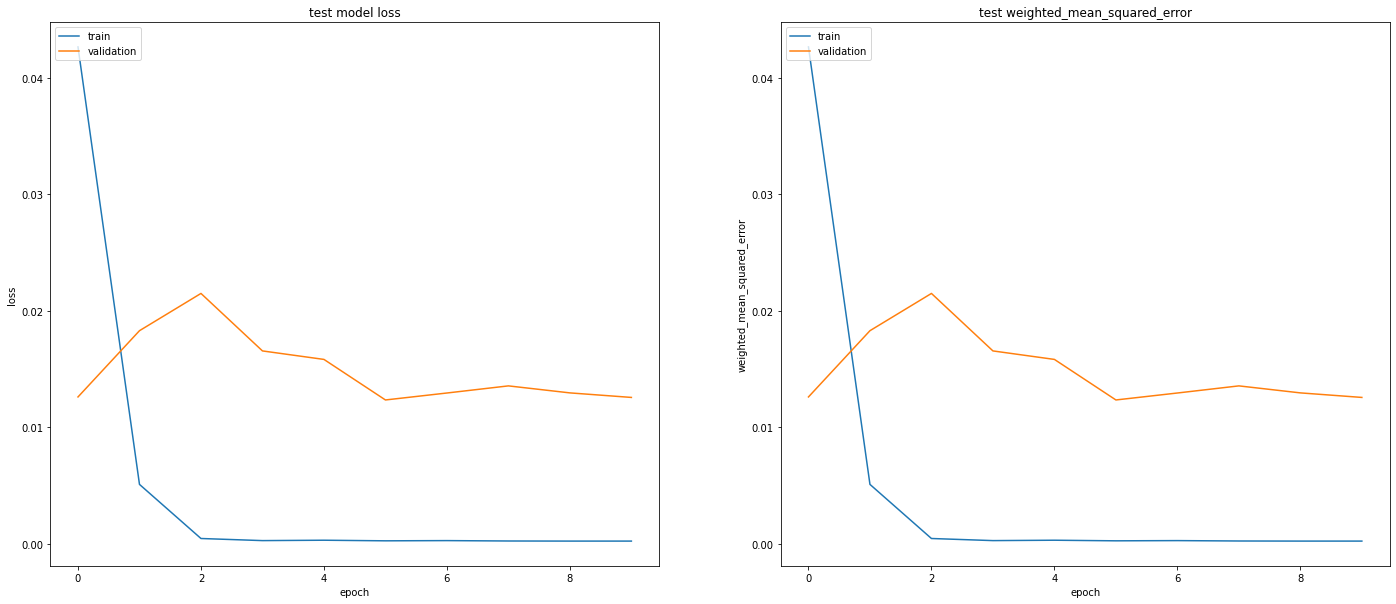

In [ ]:
import matplotlib.pyplot as plt
def plot_train(history, name='test'):
        # Determine the name of the key that indexes into the accuracy metric
        fig, axs = plt.subplots(1, 2, figsize=(24, 10))
        acc_string = 'weighted_' + Constant.ERROR
        # Plot loss
        axs[0].plot(history.history['loss'])
        axs[0].plot(history.history['val_loss'])
        axs[0].set_title(name + " " + 'model loss')
        axs[0].set_ylabel('loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend(['train', 'validation'], loc='upper left')
        # Plot accuracy
        axs[1].plot(history.history[acc_string])
        axs[1].plot(history.history['val_' + acc_string])
        axs[1].set_title(name + ' ' + acc_string)
        axs[1].set_ylabel(acc_string)
        axs[1].set_xlabel('epoch')
        axs[1].legend(['train', 'validation'], loc='upper left')
        pass
plot_train(h)

# Data Module: A combination of decorator pattern and factory pattern

With the newly proposed improved asset return prediction neural network, the variance for demands on different kinds of data and data input pipeline gets increased, thus raising importance and necessity to extend the existing data module.

**<font size=5><u>Analysis on demands</u></font>**

Now let us first do an analysis on demands of data and data input pipeline. The demand is constant in the following aspects:
* It expects to read stock data
* It expects to output standardized train, validation and test data, that should be called by model and portfolio development modules

The changing aspects of data and data input pipeline can be concluded as the following dimensions:
* Underlying data structure and algorithm: the data can be implemented in different ways, based on different data structure, generated by different algorithms
* Specific content of data, which can be further divided into:
    * whether we are looking back and predicting forward for multiple time steps, the answer is yes or no determines totally different implementation
    * different combinations of linear or element-wise data transformation, different combinations of transformation results in different combinations of methods or classes
    * which kind of shape we want the data to be, different shape may leads to totally different implementations for certain data structures
    
**<font size=5><u>Design</u></font>**

After an overwhelming research, we decide to design an architecture combing interface oriented programming concepts, together with well-known decorator pattern and factory method pattern for the data module.

<img src="./Stlearn/Data/img/Data.png" alt="framework" title="framework" width="40000" height="12000"/>

<u>**Interface oriented programming**</u>

This is a more Java concepts. Here in python by interface, we define an abstract class `Data`, whose member methods are mostly abstract and wait for its subclasses to implement. As the highest and the most abstract level of this architecture, it only defines a few methods to output the constant aspects of data and data input pipeline: it expects to output standardized train, validation and test data, that should be called by model and portfolio development modules.

```python
class Data(ABC):

    def __init__(self) -> None:
        pass

    @abstractmethod
    def get_train(self):
        return None

    @abstractmethod
    def get_val(self):
        return None

    @abstractmethod
    def log(self):
        pass

    @abstractmethod
    def generate(self, *args):
        pass

    @abstractmethod
    def X_test(self):
        return None

    @abstractmethod
    def ids_test(self):
        return None
```

We then use single inheritance to derive new subclasses of this abstract class. These subclasses differ in the way of implementation, i.e. the data structure they rely on and the algorithm they use to generate data. As mentioned above, we anticipate a large consumption of memory space, so besides the conventional way to read data in memory and transform them in memory into what we want and feed them into the model, we also implement a more memory efficient class based on generator in expectation of consuming as little memory space as we can.

```python

# implementation based on numpy array
class InMemoryData(Data, ABC):...


# implementation based on generator
class GeneratedData(Data, ABC):...
  
```


<u>**Decorator pattern**</u>

Another variance of demands in the future is classified as data's content. We realize that data's content can change in combinations of multiple dimensions, and if we use classes to represent each dataset after each combination of these dimensions, the number of classes that we have to maintain can easily explode. We hereby choose [decorator pattern](https://en.wikipedia.org/wiki/Decorator_pattern) to implement this aspect, to avoid creating too many concrete classes. To summarize, the decorator pattern solves the following problem:
* Functionalities and behavior (here refers to the transformation of data) should be added dynamically into the base concrete class object
* A flexible way of combining potential adding of behavior should be provided, rather than subclass every possible object after every such combination

Note while the decorator pattern is flexible, it is still limited by the underlying data structure of the class it is decorating. This means each implementation of class `Data` should have a corespondent group of decorators. Hence, we define two abstract decorator class for the two subclasses of `Data`. We define these two groups of decorators with the same signature in two different modules, so that we can write codes with the same signature to call decorators but defer the decision of which module to call to runtime.

```python

# InMemoryDataRecipe.py
# decorators for implementation based on numpy array
class DataDecorator(InMemoryData, ABC):

    def __init__(self, data):
        super().__init__()
        self.copy_constructor(data)
        self.generate()
        pass

    @abstractmethod
    def generate(self):
        pass
    

# GeneratedDataRecipe.py
# decorators for implementation based on generator
class DataDecorator(GeneratedData, ABC):

    def __init__(self, data):
        super().__init__()
        self.copy_constructor(data)
        self.generate()
        pass

    @abstractmethod
    def generate(self):
        pass
```

In the design of decorator pattern, we also need to provide a concrete data class for decorators to decorate. We can choose any stage within the data's transformation, but we here choose the very first stage, which is when the data gets read into the memory space from the disk.

```python

class DiskData(InMemoryData):...

class DiskData(GeneratedData):...
```

Within each module, the `DataDecorator` are subclassed to implement concrete decorators.


```python

'''
In Memory Data Decorators
'''


class InMemoryDataDecorator(DataDecorator, ABC):

    def generate(self):
        self.in_memory_data_process()
        pass

    @abstractmethod
    def in_memory_data_process(self):
        pass


class PreSplitScaler(InMemoryDataDecorator):...

'''
Pre Split Decorators
'''


class PreSplitDataDecorator(DataDecorator, ABC):

    def generate(self):
        self.pre_split_data_process()
        pass

    @abstractmethod
    def pre_split_data_process(self):
        pass


class WindowGenerator(PreSplitDataDecorator):...


'''
Split Decorators
'''


class SplitDataDecorator(DataDecorator, ABC):

    def generate(self):
        self.split_data_process()
        pass

    @abstractmethod
    def split_data_process(self):
        pass


class StandardSplitProcessor(SplitDataDecorator):...


'''
Post Split Decorators
'''


class PostSplitDataDecorator(DataDecorator, ABC):

    def generate(self):
        self.post_split_data_process()
        pass

    @abstractmethod
    def post_split_data_process(self):
        pass


class FirstDimensionReshaper(PostSplitDataDecorator, ABC):...
    

class FirstDimensionReshaperOnUnWindowed(FirstDimensionReshaper):...


class FirstDimensionReshaperOnWindowed(FirstDimensionReshaper):...


class TestDataHandlerOnFirstDimensionAsRecord(PostSplitDataDecorator):...


class TestDataHandlerOnFirstDimensionAsDate(PostSplitDataDecorator):...
```


<u>**Factory method pattern**</u>

While decorator pattern can avoid as many subclassing as we can, it however, causes inconvenience in the client side. A client must now very well which combination of decorators from data recipes he must explicitly write into the codes to get the data he wants. We hereby use [factory method pattern](https://en.wikipedia.org/wiki/Factory_method_pattern) to encapsulate the process of producing concrete data, and to provide unified and standard data products.

We first define an abstract class `DataProcessor` an interface factory for all factory subclasses. We then subclass and override the abstract method to define which combination of decorators we are choosing to produce the data. In this way, the client only cares about which factory he is calling, where the class name consist of specific dimensions and shapes for this data.

```python
class DataProcessor(ABC):
    def __init__(self, train_start, val_start, test_start, test_end, generator=False, *args):
        if generator:
            self._module = GeneratedDataRecipe
        else:
            self._module = InMemoryDataRecipe
        self._train_start = train_start
        self._val_start = val_start
        self._test_start = test_start
        self._test_end = test_end
        pass

    def load_data(self, *args):
        data = self._load_data(*args)
        data.log()
        return data

    @abstractmethod
    def _load_data(self, *args):
        pass
    
    
class TwoDimUnWinDataByStockDateByFeatureProcessor(DataProcessor):...


class ThreeDimUnWinDataByDateByStockByFeatureProcessor(DataProcessor):...

    
class ThreeDimWinDataByStockDateByWinByFeatureProcessor(DataProcessor):...


class FourDimWinDataByDateByWinByStockByFeatureProcessor(DataProcessor):

    def __init__(self, train_start, val_start, test_start, test_end, win_size, forward_size, generator=False, *args):
        self._win_size = win_size
        self._forward_size = forward_size
        super().__init__(train_start, val_start, test_start, test_end, generator)

    def _load_data(self):
        data = self._module.DiskData(self._train_start, self._val_start, self._test_start, self._test_end)
        data = self._module.PreSplitScaler(data)
        data = self._module.WindowGenerator(data, self._win_size, self._forward_size)
        data = self._module.StandardSplitProcessor(data)
        data = self._module.FirstDimensionReshaperOnWindowed(data)
        data = self._module.TestDataHandlerOnFirstDimensionAsDate(data)
        return data

```

**<font size=5><u>Implementation</u></font>**

The abstract class `Data` is implemented by the following two subclasses:
* `InMemoryData`: 
    * is based on data structure `numpy.ndarray`
    * reads disk data directly into memory space and apply transformation on the whole piece of memory data, finally feed the whole memory data into the model
* `GeneratedData`
    * is based on self-defined data structure `ArrayGenerator`
    * reads disk data directly into memory space 
    * when calling by model, use `ArrayGenerator` object to iterate through sub and small pieces of memory data and apply transformation on this small piece of memory data, which result is then forwarded into model
    
<u>**GeneratedData and ArrayGenerator**</u>
    
The `GeneratedData` is developed to solve the heavy consumption on memory space of training data. If we exclude the data originally read in, then the memory space `InMemoryData` objects consume is $O(N)$, where $N$ denotes the number of records/samples, whereas the memory space `GeneratedData` objects consume is $O(1)$.

We introduce the following skeleton for the underlying data structure `ArrayGenerator` for `GeneratedData`. An `ArrayGenerator`: object needs the following component to generate data:
* `batch size`: denotes how many samples are we generating each time. While generating one sample each time consumes the least memory as possible, it may take too long time for model training. We hereby set this to be a variable that can be configured and tuned
* `_memory_data`: the base data stored in memory that we are iterating through and generating data from
* `_memory_data_index_range`: the list of available indexes of the base data `_memory_data` that we can iterating through. Note this cannot always be `range(_memory_data.shape[0])`, for some operations and transformations such as generating data window may make some of these indexes (records) not legitimate any more
* `_cur_indexes_on_memory_data_index`: the index list of `_memory_data_index_range` that we are generating from in the current step. This should be an `numpy.ndarray` as we do increment operation on it. Due to the possibility of reshaping, this list doesn't necessarily have only one element
* `_steps`: the number used to increment `_cur_indexes_on_memory_data_index` each iteration. It should be set to 1 if we don't want to skip anything
* `_count`: how many iteration we have gone so far
* `_limit`: how many iterations we can go
* `_last_mod`: the `batch size` may not cover all the samples equally, so we need a mod to adjust the batch size output by the last iteration
* `_ops_funcs`: list to store the operations/functions a generator should perform to output its data

Suppose we have already set all variables, when called, an `ArrayGenerator` object will
* determine a list of indexes to slice `_memory_data` based on `_cur_indexes_on_memory_data_index` and `_memory_data_index_range`
* slice data with the determined indexes from `_memory_data`
* forward this data into each function in `_ops_funcs` sequentially
* update the `_cur_indexes_on_memory_data_index` by `_steps` to prepare for the next iteration
* return the data

Hence, at the data prerprocessing stage before feeding data into model, what each `DataDecorator` for `GeneratedData` do is configure the variables mentioned above, so that `ArrayGenerator` know where to find and how to compute when it is called by the model. This is totally different from what we do to the whole memory data, where we do all computation at first then forward the processed data into model.

`GeneratedData` is hereby, an implementation based on `ArrayGenerator`, where most of its member variable are set to be `ArrayGenerator`. It also provides wrapper functions to convert `ArrayGenerator` into `tf.data.Dataset` readable by TensorFlow.
    
```python
class ArrayGenerator(Generator):

    def __init__(self, memory_data,
                 memory_data_index_range=None, data_shape=None,
                 ops_funcs=None, start_indexes_on_index=None):
        self.batch_size = ...
        self._memory_data = ...
        self._memory_data_index_range = ...
        self._data_shape = ...
        self._cur_indexes_on_memory_data_index = ...
        self._steps = ...
        self._count = 0
        self._limit = ...
        self._last_mod = ...
        self._ops_funcs = []
        super().__init__()
        self._start_indexes_on_indexes = ...
        pass

    def _compute(self, data):...

    def reset(self):...

    def send(self, ignored_arg):...

    def throw(self, type=None, value=None, traceback=None):...
        
    def update_memory_data(self, memory_data):...

    def update_indexes(self, indexes):...

    def update_index_range(self, index_range):...

    def add_ops_funcs(self, func):...
        
    def update_shape(self, shape):...

    def update_limit(self, limit):...

    def clear_ops_funcs(self):...

    def update_batch_size(self, size):...

    @property
    def shape(self):...

    @property
    def memory_data_index_range(self):...

    @property
    def cur_indexes_on_memory_data_index(self):...

    @property
    def ops_funcs(self)...

    def generate_all(self):...
       
```

        
<u>**Details of data decorators**</u>

As presented before, `InMemoryData` and `GeneratedData` both have fully implemented `DataDecorators` to perform data preprocessing. A full list of these `DataDecorators` are:

* Pre Split Decorators:
    * `PreSplitScaler` 
    * `WindowGenerator`
* Split Decorators:
    * `StandardSplitProcessor`
* Post Split Decorators:
    * `FirstDimensionReshaperOnUnWindowed`
    * `FirstDimensionReshaperOnWindowed`
    * `TestDataHandlerOnFirstDimensionAsRecord`
    * `TestDataHandlerOnFirstDimensionAsDate`
    
Here we only illustrate some important decorators.

`WindowGenerator` converts the current data into time series data, where we can collect all features during a past period within the given `_data_window_size` and predict all labels during a future period within the given `_forward_steps_size`. We should skip a number of very first samples for each ticker because they don't contain sufficient information.
* For `InMemoryData`, we only write a for loop to iteratively update features for each record to contain the look back window and update labels for each record to contain the look forward window. We update the indexes for training, validation and test data excluding those who cannot provide sufficient information
* For `GeneratedData`, we configure the member variables of each component generator by:
    * update the `_memory_data_index_range` for training, validation and test data generators excluding those who cannot provide sufficient information
    * extract the logic in a single iteration in the for loop conducted by `InMemoryData` and append them into the `_ops_funcs` of these generators
    
`StandardSplitProcessor` split the current data into train, validation and test dataset.
* For `InMemoryData`, we perform a very simple slice data operation on `_X` and `_y` variable based on indexes for training, validation and test dataset, then assign them into correspondent member variables
* For `GeneratedData`, we configure the member variables of each component generator by:
    * Constructing new `ArrayGenerator` objects for corresponding variables, passing into them of
    * Shared memory data, correspondent index ranges, shape and accumulated operation function list
    
The two `FirstDimensionReshaper` targets on different possible input data. They both rearrange and transpose the current data by splitting the first dimension from *per stock per date* to two separate dimensions where *date* takes the first dimension and *stock* takes the second.
* For `InMemoryData`, we directly pass the current data into reshape and transpose functions then output the data
* For `GeneratedData`, we configure the member variables of each component generator by:
    * Updating the starting `_cur_indexes_on_memory_data_index` member variable, since the first dimension of the output data is different from the memory data now we have to do computation to make the indexes re-locate samples of the memory data that will be able to fully transformed into samples in output shape
    * Append the reshape and transpose function into the operation function list
    
We are fully aware of some limitations on implementation of `DataDecorator` for `GeneratedData`. While all linear and element-wise decorators can be chained for any times and in any order, some non-linear transformation is subject to specific order. For instance:
* `WindowGenerator` must be applied on the memory_data, meaning it must be placed in the first order

Some findings:
* **We have run tests and proved that `GeneratedData` outputs perfectly same data with `InMemoryData`**
* **`GeneratedData` can handle data size up to 20 years, but `InMemoryData` for 1 year crashes python interpreter on a machine with RAM of 16 GB**